In [1]:
# Setup Revise for automatic reloading during development
using Pkg
Pkg.add("Revise")
using Revise

   Resolving package versions...
      Compat entries added for 
      Compat entries added for 
  No Changes to `~/master_thesis/LorenzParameterEstimation/Project.toml`
  No Changes to `~/master_thesis/LorenzParameterEstimation/Manifest.toml`
  No Changes to `~/master_thesis/LorenzParameterEstimation/Project.toml`
  No Changes to `~/master_thesis/LorenzParameterEstimation/Manifest.toml`


# Theta Parameter Estimation in Modified Lorenz 63

This notebook demonstrates a challenging test case for parameter estimation using the `LorenzParameterEstimation` package: learning the theta parameter in a modified Lorenz 63 system.

## Problem Description

We modify the standard Lorenz 63 system by introducing a theta parameter in the y-equation:
- dx/dt = σ(y - x)
- dy/dt = **θ**x(ρ - z) - y  ← Modified with theta parameter
- dz/dt = xy - βz

**Key challenge**: The parameter space is fractal - for some theta values the strange attractor collapses, for others it reemerges without changing the overall shape too much.

**Critical theta values of interest:**
- θ = 1.0 (default/standard)
- θ = 3.5 (attractor changes)
- θ = 4.0 (different behavior)  
- θ = 4.6 (yet another regime)

**Gradient challenge**: Computing gradients through this fractal parameter space is extremely challenging, demonstrating the limits of gradient-based optimization and the robustness of the package's Enzyme.jl integration.

## Setup and Imports

In [2]:
# Activate the local LorenzParameterEstimation package
import Pkg
Pkg.activate("../../")  # Activate the main project environment
Pkg.instantiate()  # Ensure all dependencies are installed

using DifferentialEquations
using Plots
using Random
using LinearAlgebra
using Statistics
using Enzyme

using LorenzParameterEstimation

# Set random seed for reproducibility
Random.seed!(42)

  Activating project at `~/master_thesis/LorenzParameterEstimation`


TaskLocalRNG()

In [3]:
base_params = classic_params()
println("Base params: $base_params")

# Add theta shifts: θ = 3.5
theta_stretched_3_5 = with_theta(base_params, 3.5)
println("Theta stretched: $theta_stretched_3_5")

# Add theta shifts: θ = 4.0
theta_stretched_4_0 = with_theta(base_params, 4.0)
println("Theta stretched: $theta_stretched_4_0")

# Add theta shifts: θ = 4.6
theta_stretched_4_6 = with_theta(base_params, 4.6)
println("Theta stretched: $theta_stretched_4_6")


# Test parameter utilities
parameter_summary(base_params)
println()
parameter_summary(theta_stretched_3_5)

Base params: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.0)
Theta stretched: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 3.5)
Theta stretched: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 4.0)
Theta stretched: L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 4.6)
L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: None (all zero)
  Theta modification: None (θ=1)

L63Parameters Summary:
  Core parameters: σ=10.0, ρ=28.0, β=2.6666666666666665
  Coordinate shifts: None (all zero)
  Theta modification: θ=3.5


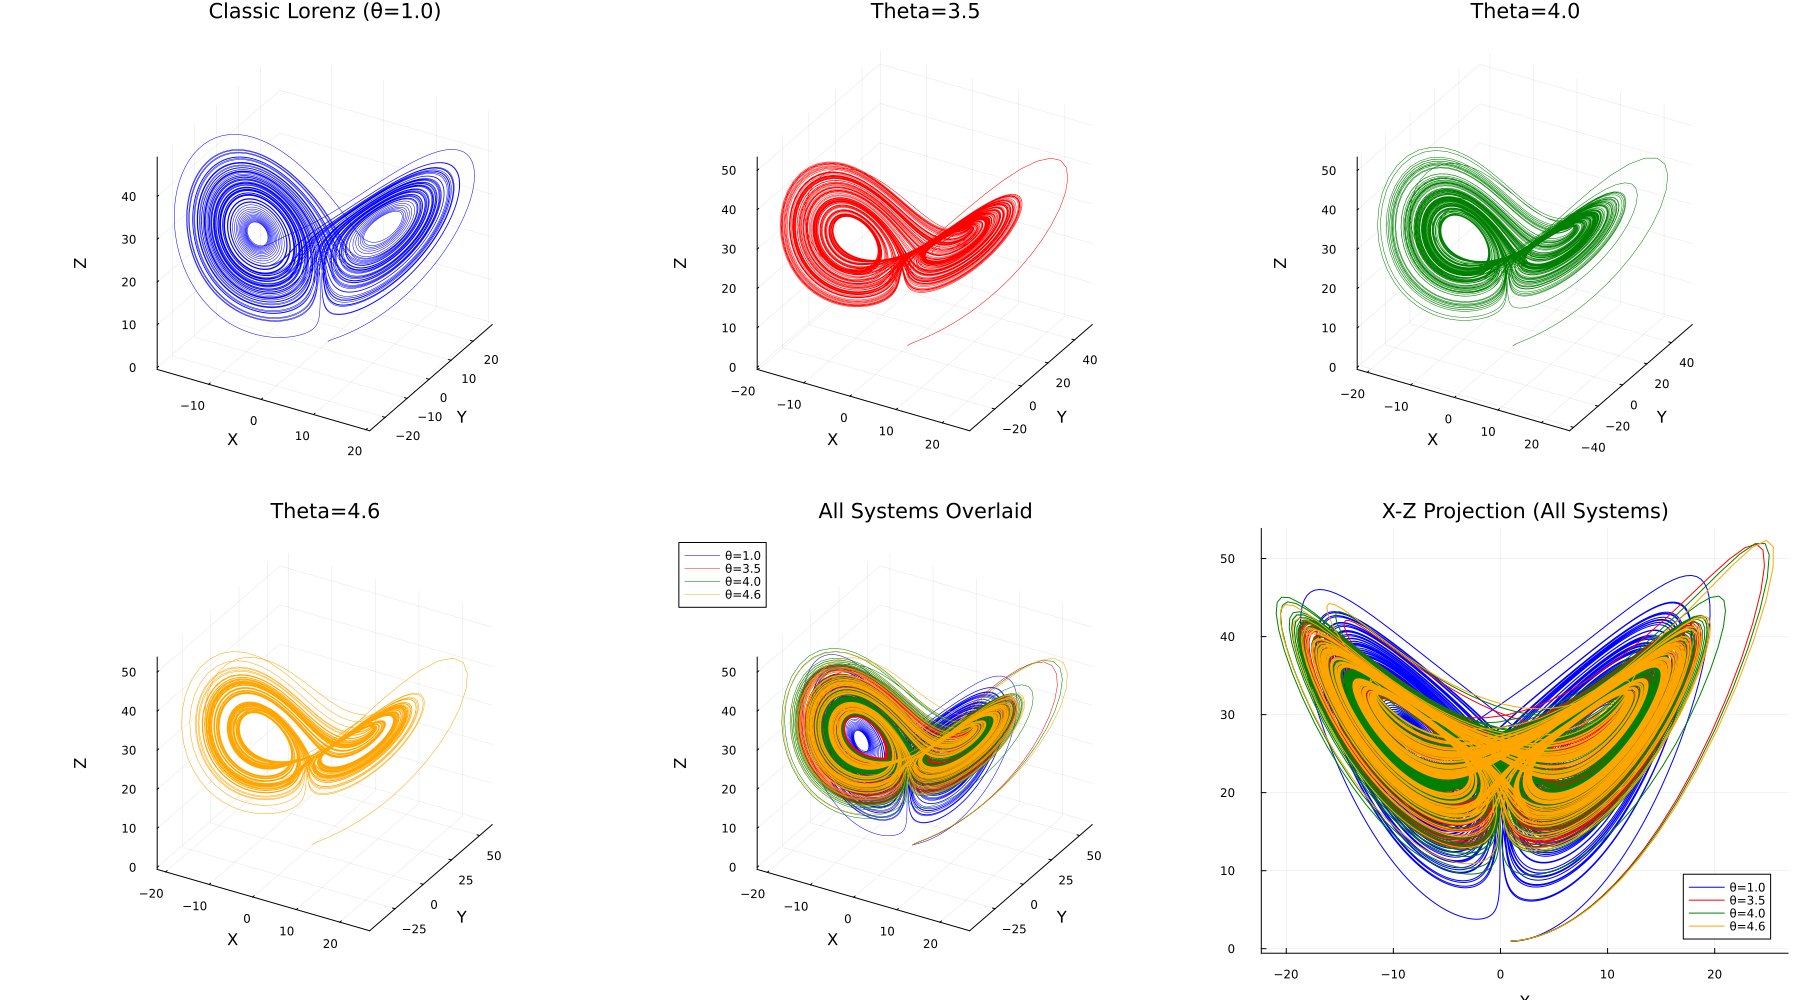

In [4]:
# Initial condition 
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate all systems
sol_basic = integrate(base_params, u0, (0.0, T), dt)
sol_stretched_3_5 = integrate(theta_stretched_3_5, u0, (0.0, T), dt)
sol_stretched_4_0 = integrate(theta_stretched_4_0, u0, (0.0, T), dt)
sol_stretched_4_6 = integrate(theta_stretched_4_6, u0, (0.0, T), dt)

# Plot settings
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)

# Individual 3D plots
p1 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
          title="Classic Lorenz (θ=1.0)", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:blue, kwargs3d...)

p2 = plot(sol_stretched_3_5.u[:, 1], sol_stretched_3_5.u[:, 2], sol_stretched_3_5.u[:, 3];
          title="Theta=3.5", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:red, kwargs3d...)

p3 = plot(sol_stretched_4_0.u[:, 1], sol_stretched_4_0.u[:, 2], sol_stretched_4_0.u[:, 3];
          title="Theta=4.0", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:green, kwargs3d...)

p4 = plot(sol_stretched_4_6.u[:, 1], sol_stretched_4_6.u[:, 2], sol_stretched_4_6.u[:, 3];
          title="Theta=4.6", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:orange, kwargs3d...)

# Overlay plot with all systems
p5 = plot(sol_basic.u[:, 1], sol_basic.u[:, 2], sol_basic.u[:, 3];
          title="All Systems Overlaid", xlabel="X", ylabel="Y", zlabel="Z",
          linecolor=:blue, label="θ=1.0", linewidth=0.5, seriestype=:path3d, legend=true)
plot!(p5, sol_stretched_3_5.u[:, 1], sol_stretched_3_5.u[:, 2], sol_stretched_3_5.u[:, 3];
      linecolor=:red, label="θ=3.5", linewidth=0.5, seriestype=:path3d)
plot!(p5, sol_stretched_4_0.u[:, 1], sol_stretched_4_0.u[:, 2], sol_stretched_4_0.u[:, 3];
      linecolor=:green, label="θ=4.0", linewidth=0.5, seriestype=:path3d)
plot!(p5, sol_stretched_4_6.u[:, 1], sol_stretched_4_6.u[:, 2], sol_stretched_4_6.u[:, 3];
      linecolor=:orange, label="θ=4.6", linewidth=0.5, seriestype=:path3d)

# X-Z projection with all systems
p6 = plot(sol_basic.u[:, 1], sol_basic.u[:, 3];
          title="X-Z Projection (All Systems)", xlabel="X", zlabel="Z",
          linecolor=:blue, label="θ=1.0", legend=true)
plot!(p6, sol_stretched_3_5.u[:, 1], sol_stretched_3_5.u[:, 3];
      linecolor=:red, label="θ=3.5")
plot!(p6, sol_stretched_4_0.u[:, 1], sol_stretched_4_0.u[:, 3];
      linecolor=:green, label="θ=4.0")
plot!(p6, sol_stretched_4_6.u[:, 1], sol_stretched_4_6.u[:, 3];
      linecolor=:orange, label="θ=4.6")

plot(p1, p2, p3, p4, p5, p6, layout=(2,3), size=(1800, 1000))


In [5]:
# Create initial guess parameters (starting from base params)
initial_params = with_theta(base_params, 1.0)  # Start with θ=1.0

results = modular_train!(
    initial_params,                                     # Initial parameter guess
    sol_stretched_3_5;                                  # Target trajectory to fit,                  
    loss_function = window_rmse,                        # Loss function                                         
    optimizer_config = adam_config(learning_rate=0.1),                    # Optimizer configuration
    epochs = 400,                                       # Number of training epochs
    window_size = 300,                                  # Size of trajectory windows
    batch_size = 32,                                    # Mini-batch size
    update_σ = false,                                   # Don't update σ parameter
    update_ρ = false,                                   # Don't update ρ parameter
    update_β = false,                                   # Don't update β parameter
    update_x_s = false,                                 # Don't update x_s coordinate shift
    update_y_s = false,                                 # Don't update y_s coordinate shift
    update_z_s = false,                                 # Don't update z_s coordinate shift
    update_θ = true,                                    # Update θ parameter
    verbose = true,                                     # Print training progress
    eval_every = 1,                                     # Evaluate every epoch
    early_stopping_patience = 40,                       # Early stopping patience
)

   Optimizer: Adam
   Data: 106 train windows, 26 val windows
   Window size: 300, stride: 150
   Updating: θ

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │  11.440635 │  11.188013 │ θ=1.396   Data: 106 train windows, 26 val windows
   Window size: 300, stride: 150
   Updating: θ

Epoch │   Train    │    Val     │ Parameters
──────┼────────────┼────────────┼────────────────────────────
    1 │  11.440635 │  11.188013 │ θ=1.396
    2 │  10.513258 │  11.048158 │ θ=1.741
    3 │  10.721493 │  11.064260 │ θ=1.912
    4 │  10.838114 │  11.039400 │ θ=1.998
    5 │  10.716001 │  11.364421 │ θ=2.064
    6 │  10.815631 │  11.384773 │ θ=2.107
    7 │  10.648301 │  11.259378 │ θ=2.167
    8 │  10.683412 │  11.172760 │ θ=2.211
    9 │  10.532502 │  11.040541 │ θ=2.288
    2 │  10.513258 │  11.048158 │ θ=1.741
    3 │  10.721493 │  11.064260 │ θ=1.912
    4 │  10.838114 │  11.039400 │ θ=1.998
    5 │  10.716001 │  11.364421 │ θ=2.

(best_params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 3.499823642306099), metrics_history = NamedTuple[(epoch = 1, train_loss = 11.440634621225545, val_loss = 11.188012856671703, params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.3956487303006677)), (epoch = 2, train_loss = 10.513257662402651, val_loss = 11.048158275689689, params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.741494315748237)), (epoch = 3, train_loss = 10.721492739640551, val_loss = 11.064260043953114, params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.9124432205246726)), (epoch = 4, train_loss = 10.838113741347955, val_loss = 11.0393999051654, params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 1.9983980931915484)), (epoch = 5, train_loss = 10.716000641683046, val_loss = 11.364420917940123, params = L63Parameters{Float64}(10.0, 28.0, 2.6666666666666665, 0.0, 0.0, 0.0, 2.0639